# 05 Results Analysis

This notebook includes the code for the buas analysis and validation. Parameters such as method, situation, dictionary, etc. might need to be specified specifically to replicate all graphs and results from the thesis.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import ttest_ind
import math
import pathlib
from itertools import repeat
import ast
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings("ignore")

In [2]:
male_color_code = "black"
female_color_code = '#3AA8F3'

In [3]:
# Import company list. 
company_names = pd.read_csv("sp500companynames_clean.csv", sep = ";", index_col = 0)
company_names.dropna(inplace = True)
company_names.rename(columns = {"companyname":"Name"}, inplace = True)
company_names["Name"] = company_names["Name"].str.lower()

# Load and clean list of english nouns and generate random sample.
nouns = pd.read_csv('nouns.csv', sep=";")
nouns = nouns[nouns['nouns'].str.strip().str.split(' ').str.len().eq(1)] # Only considering single word nouns.
nouns_sample = nouns["nouns"].sample(n = 800, random_state = 42)
nouns_sample = list(nouns_sample)

# Load action verbs.
action_verbs = pd.read_csv("action_verbs_final.csv", sep = ";", index_col = 0)

# Import and prepare dictionaries. 
dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries = dictionaries[dictionaries.Dictionary != "Politics"].reset_index()
dictionaries["tuple"] = list(zip(dictionaries["Term2"].astype(str), dictionaries["Term1"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)

unique_dictionaries = dictionaries.drop_duplicates(subset='tuple', keep="last")
unique_dictionaries.reset_index(inplace = True)

context_list = ["works", "worked", "will work", "has worked", "is working","is employed", "was employed", "will be employed", "has been employed"]

companies = company_names["Name"]


In [4]:
# Set parameters. 
sign_level = 0.05
method = "Pronouns"
situation = "Work"
topn = 20
situation_set = ["Communication", "Creative", "Helping", "Leadership", "Organizational", "Quantitative", 
                "Research", "Teaching", "Technical", "Work"]

## 1. Dimension Bias

In [5]:
# Define helper functions. 

def read_embedding_values(company_names, antonym_pair, method): 
    
    result = pd.DataFrame()
    result["company"] = company_names
    result["value_male"] = 0
    result["value_female"] = 0
    result["value_neutral"] = 0 
    result["difference"] = 0

    for company in company_names: 
        comparison = pd.read_csv(f"./01_Embeddings/{method}/{company}_context_average.csv")

        comparison = comparison.groupby("tuple", as_index = False).mean() # Account for duplicates.         
        value_male = float(comparison[comparison["tuple"] == antonym_pair]["context_average_male"])
        value_female = float(comparison[comparison["tuple"] == antonym_pair]["context_average_female"])
        #value_neutral = float(comparison[comparison["tuple"] == antonym_pair]["context_average_neutral"])
        
        difference = value_female - value_male
        result["value_male"].loc[result["company"] == company] = value_male
        result["value_female"].loc[result["company"] == company] = value_female
        #result["value_neutral"].loc[result["company"] == company] = value_neutral
        result["difference"].loc[result["company"] == company] = difference
    
    return result   

def check_significance(p_value): 
    if p_value < 0.05: 
        stat_res = "Significant Difference"
    else: 
        stat_res = "No Significant Difference"
        
    return stat_res

def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

## 1.1 Get individual dimension distributions

In [6]:
def get_dimension_distribution(considered_companies, antonym_pair, nouns_sample, method): 
    
    result = read_embedding_values(considered_companies, antonym_pair, method)
    rand_result = read_embedding_values(nouns_sample, antonym_pair, method)
    
    fig = plt.figure(constrained_layout=True, figsize=(10, 4))
    gs = GridSpec(2, 1, figure=fig)
    fig.suptitle(f"Distributions for {str(antonym_pair)}", weight="bold")

    # Plot male and female distribution 
    stat, p_value = ttest_ind(result["value_male"], result["value_female"])
    ax1 = fig.add_subplot(gs[0, :])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_title(f"Male vs. Female Firm Distribution ({check_significance(p_value)}, p-value = {round_decimals_up(p_value, 4)})", fontsize=9)
    sns.distplot(result["value_male"], ax = ax1, label = "Male Context", color = male_color_code)
    sns.distplot(result["value_female"], ax = ax1, label = "Female Context", color = female_color_code)
    ax1.set_xlabel("Polar Score")
    plt.axvline(result["value_male"].mean(), color = male_color_code, label = "Mean Male")
    plt.axvline(result["value_female"].mean(), color = female_color_code, label = "Mean Female")
    plt.legend() 
    
    # Plot difference
    stat, p_value = ttest_ind(result["difference"], rand_result["difference"])
    ax4 = fig.add_subplot(gs[1, :])
    ax4.set_title(f"Corporate vs. Random Difference ({check_significance(p_value)}, p-value = {round_decimals_up(p_value, 4)})", fontsize=9)
    sns.distplot(result["difference"], ax = ax4, label = "Firm Difference", color = "cyan")
    sns.distplot(rand_result["difference"], ax = ax4, label = "Random Difference", color = "grey")
    plt.axvline(rand_result["difference"].mean(), color = "grey")
    plt.axvline(result["difference"].mean(), color = "cyan")
    
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    plt.legend()
    
    #pathlib.Path(f'./plots/{method}/').mkdir(parents=True, exist_ok=True) 
    #plt.savefig(f'./plots/{method}/{antonym_pair}.png', bbox_inches = "tight",transparent=True)

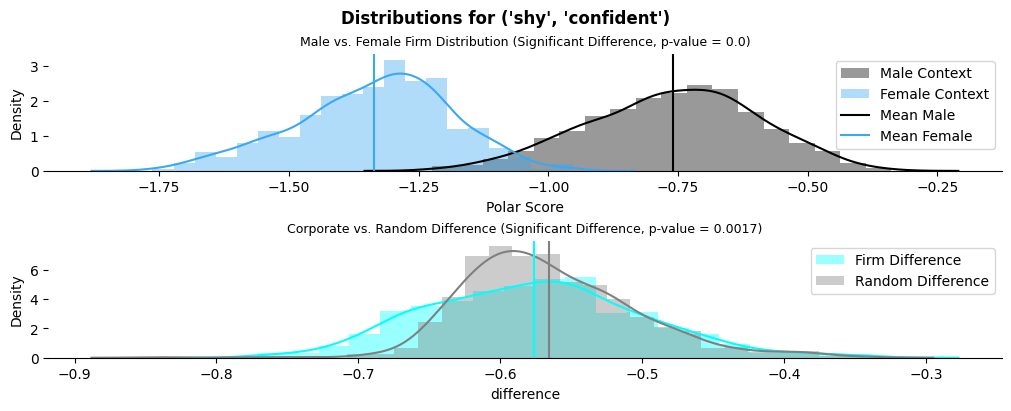

In [7]:
get_dimension_distribution(companies, "('shy', 'confident')", nouns_sample, f"Embedd_{method}/{situation}_context")

## 1.2 Get dimension overview

In [8]:
def get_dimension_significance(res_table):
    
    # Get dataframe. 
    dimension_analysis_df = pd.DataFrame({"Favors Male Embedding":[
    len(res_table[res_table.iloc[:, 3] < 0]), 
    len(res_table[(res_table.iloc[:, 3] < 0) & (res_table.iloc[:, 1] < sign_level)]),
    len(res_table[(res_table.iloc[:, 3] < 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level)]),
    len(res_table[(res_table.iloc[:, 3] < 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level) & (res_table.iloc[:, 3] < res_table.iloc[:, 4])])    
    ],
                                        "Favors Female Embedding":[
    len(res_table[res_table.iloc[:, 3] > 0]), 
    len(res_table[(res_table.iloc[:, 3] > 0) & (res_table.iloc[:, 1] < sign_level)]), 
    len(res_table[(res_table.iloc[:, 3] > 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level)]), 
    len(res_table[(res_table.iloc[:, 3] > 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level) & (res_table.iloc[:, 3] > res_table.iloc[:, 4])])      
    ]    
    },
    index = ["All Dimensions", "Male ≠ Female Embedding", "Δ Firm ≠ Δ Random", "Firm Bias > Random Bias"]
    )
    
    return dimension_analysis_df

In [9]:
results_dict = {}
for situation in situation_set: 
    results_dict[situation] = pd.read_csv(f"./01_Embeddings/Embedd_{method}/{situation}_context/{situation}_Significance.csv", index_col = 0)
    
dimension_results_dict = {}
for situation in situation_set: 
    dimension_results_dict[situation] = get_dimension_significance(results_dict[situation])

In [10]:
top_favoring_male = results_dict[situation][results_dict[situation]["Mean Firm"] < 0]
top_favoring_male['Dimension'] = top_favoring_male['Dimension'].apply(ast.literal_eval)
top_favoring_male["Left"], top_favoring_male["Right"] = zip(*top_favoring_male["Dimension"])
top_favoring_male.loc[top_favoring_male["P-Value M vs. F Firm Embedding"] < 0.05, "Right"] = top_favoring_male.loc[top_favoring_male["P-Value M vs. F Firm Embedding"] < 0.05, "Right"].astype(str) + "*"
top_favoring_male.loc[(top_favoring_male["P-Value Delta Firm vs. Delta Random Embedding"] < 0.05) & (top_favoring_male["Mean Firm"] < top_favoring_male["Mean Random"]), "Right"] = top_favoring_male.loc[(top_favoring_male["P-Value Delta Firm vs. Delta Random Embedding"] < 0.05) & (top_favoring_male["Mean Firm"] < top_favoring_male["Mean Random"]), "Right"].astype(str) + "*"

top_favoring_female = results_dict[situation][results_dict[situation]["Mean Firm"] > 0]
top_favoring_female['Dimension'] = top_favoring_female['Dimension'].apply(ast.literal_eval)
top_favoring_female["Left"], top_favoring_female["Right"] = zip(*top_favoring_female["Dimension"])
top_favoring_female.loc[top_favoring_female["P-Value M vs. F Firm Embedding"] < 0.05, "Right"] = top_favoring_female.loc[top_favoring_female["P-Value M vs. F Firm Embedding"] < 0.05, "Right"].astype(str) + "*"
top_favoring_female.loc[(top_favoring_female["P-Value Delta Firm vs. Delta Random Embedding"] < 0.05) & (top_favoring_female["Mean Firm"] < top_favoring_female["Mean Random"]), "Right"] = top_favoring_female.loc[(top_favoring_female["P-Value Delta Firm vs. Delta Random Embedding"] < 0.05) & (top_favoring_female["Mean Firm"] < top_favoring_female["Mean Random"]), "Right"].astype(str) + "*"

all_dimensions = pd.concat([top_favoring_male, top_favoring_female])
top_dimensions = pd.concat([top_favoring_male.sort_values("Mean Firm").head(topn), top_favoring_female.sort_values("Mean Firm", ascending = False).head(topn)])
top_dimensions.reset_index(drop = True, inplace = True)
top_dimensions = top_dimensions.sort_values("Mean Firm")

(-1.670108390140665, 1.670108390140665)

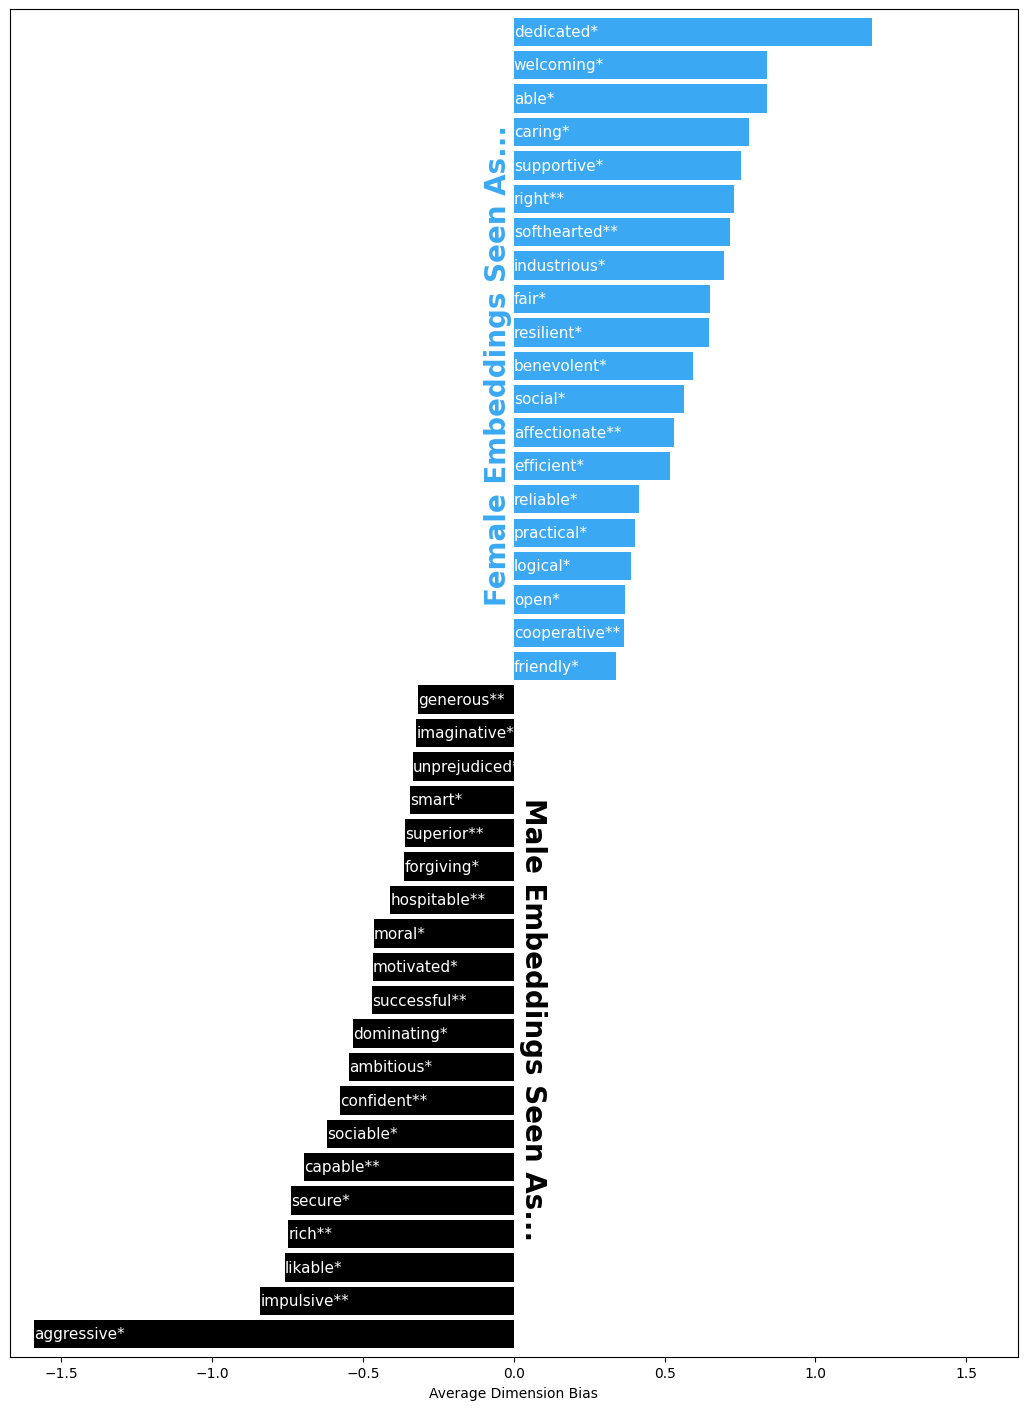

In [11]:
fig, ax = plt.subplots(figsize=(13, 17.5))


ax = top_dimensions['Mean Firm'].plot(kind='barh',color = (top_dimensions['Mean Firm'] > 0).map({True: female_color_code, False: male_color_code}), width=0.85)

for i, (p, pr) in enumerate(zip(top_dimensions["Right"], top_dimensions["Mean Firm"])):
    
    if pr > 0: 
        plt.text(s=p, x=0, y=i, color="white", verticalalignment="center", size=11)
        
    else: 
        plt.text(s=p, x=pr, y=i, color="white", verticalalignment="center", size=11)

ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax.set_xlabel("Average Dimension Bias")

limit = top_dimensions["Mean Firm"].abs().max()*1.05

ax.text(limit*0.01,3, "Male Embeddings Seen As...", rotation =270, size = 20, weight = "bold")
ax.text(limit*-0.06,22, "Female Embeddings Seen As...", rotation =90, size = 20, weight = "bold", color =female_color_code )

ax.set_xlim(-limit, limit)
#ax.set_title("Honorable Woman, Rational Men – Highest Average Dimension Bias for Embedding Firms", weight = "bold")
#plt.savefig('firms_bias_summary.pdf', bbox_inches = "tight",transparent=True)

Text(0.5, 0.93, 'Embedding Pronouns: Dimension Bias Significance across Situations')

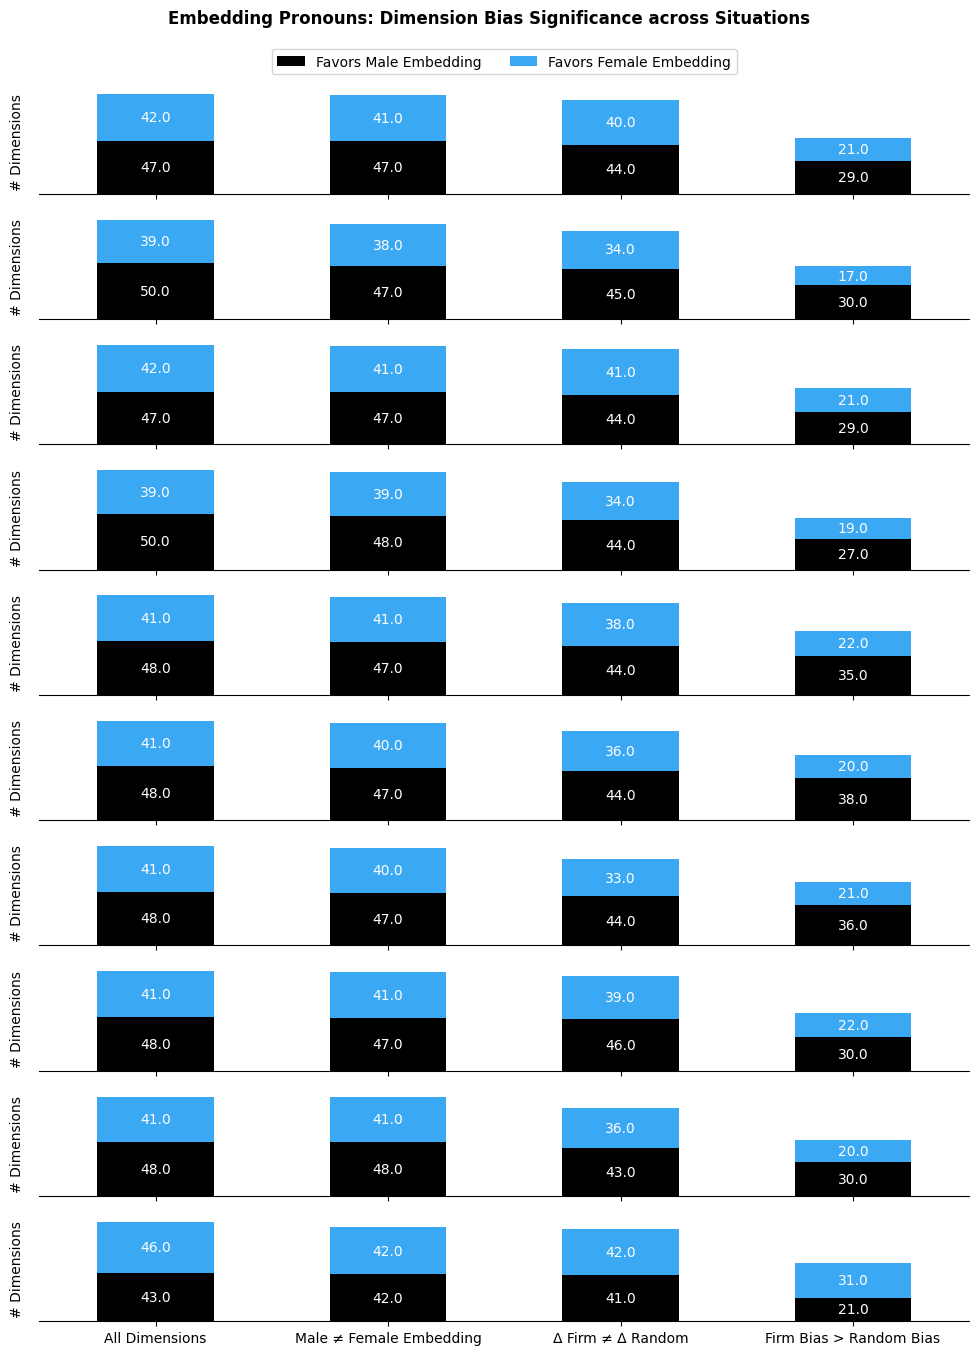

In [12]:
fig, axs = plt.subplots(10,1, figsize=(12, 16))
axs = axs.ravel()

for i, situation in zip(range(10), situation_set):

    dimension_results_dict[situation].plot(kind='bar', stacked=True, color=[male_color_code, female_color_code], ax = axs[i])
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    for c in axs[i].containers:
        labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
        axs[i].bar_label(c, labels=labels, label_type='center', color = "white")
    #axs[i].get_legend().remove()
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=0)
    axs[i].set_ylabel("# Dimensions")
    
    axs[i].set_yticklabels([])
    axs[i].tick_params(left=False)
    
    axs[i].legend(bbox_to_anchor=(0, 1.4, 1, 0.05), loc='upper center',  ncol = 2)
    if i != 0: 
        axs[i].get_legend().remove()
    
    if i != 9: 
        axs[i].set_xticklabels([])
        
fig.suptitle(f"Embedding {method}: Dimension Bias Significance across Situations", weight = "bold", y=0.93)
#plt.savefig(f'{method}_dimension_significance.pdf', bbox_inches = "tight",transparent=True)

Text(0.5, 1.2, 'Embedding Pronouns: Dimension Bias Significance')

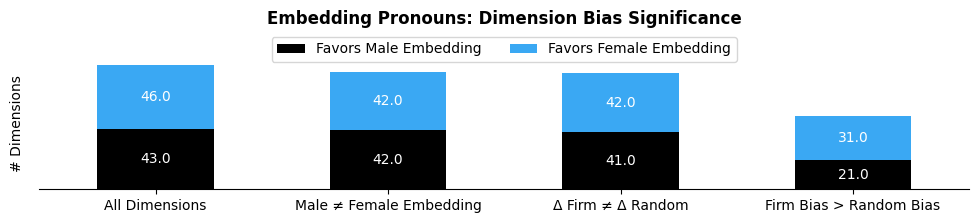

In [13]:
fig, axs = plt.subplots(1,1, figsize=(12, 1.7))

dimension_results_dict["Work"].plot(kind='bar', stacked=True, color=[male_color_code, female_color_code], ax = axs)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
for c in axs.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    axs.bar_label(c, labels=labels, label_type='center', color = "white")
#axs[i].get_legend().remove()
axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=0)
axs.set_ylabel("# Dimensions")

axs.set_yticklabels([])
axs.tick_params(left=False)

axs.legend(bbox_to_anchor=(0, 0.92, 1, 0.05), loc='lower center',  ncol = 2)
        
axs.set_title(f"Embedding {method}: Dimension Bias Significance", weight = "bold", y=1.2)
#plt.savefig(f'{method}_dimension_overview.pdf', bbox_inches = "tight",transparent=True)

## 2. Dictionary Results

In [14]:
# Import and prepare dictionaries. 
dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries = dictionaries[dictionaries.Dictionary != "Politics"].reset_index()
dictionaries["tuple"] = list(zip(dictionaries["Term2"].astype(str), dictionaries["Term1"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)

unique_dictionaries = dictionaries.drop_duplicates(subset='tuple', keep="last")
unique_dictionaries.reset_index(inplace = True)

In [15]:
def get_dictionary_results(res_table): 

    dictionary_results = {}

    favors_male = []
    favors_female = []

    for dictionary in dictionaries["Dictionary"].unique(): 
        num_dim = len(res_table[res_table["Dictionary"] == dictionary])
        favoring_male = len(res_table[(res_table["Dictionary"] == dictionary) & (res_table["Mean Firm"] < 0)])
        favoring_female = len(res_table[(res_table["Dictionary"] == dictionary) & (res_table["Mean Firm"] > 0)])
        perc_male = favoring_male / num_dim
        perc_female = favoring_female / num_dim
        favors_male.append(perc_male)
        favors_female.append(perc_female)
        dictionary_results["Favors Male Embedding"] = favors_male
        dictionary_results["Favors Female Embedding"] = favors_female

    dictionary_results_df = pd.DataFrame(dictionary_results, index = dictionaries["Dictionary"].unique())
    return dictionary_results_df

In [16]:
results_dict = {}
for situation in situation_set: 
    results_dict[situation] = pd.read_csv(f"./01_Embeddings/Embedd_{method}/{situation}_context/{situation}_Significance.csv", index_col = 0)
    
dictionary_results_dict = {}
for situation in situation_set: 
    dictionary_results_dict[situation] = get_dictionary_results(results_dict[situation])

## 2.1 Get dictionary overview

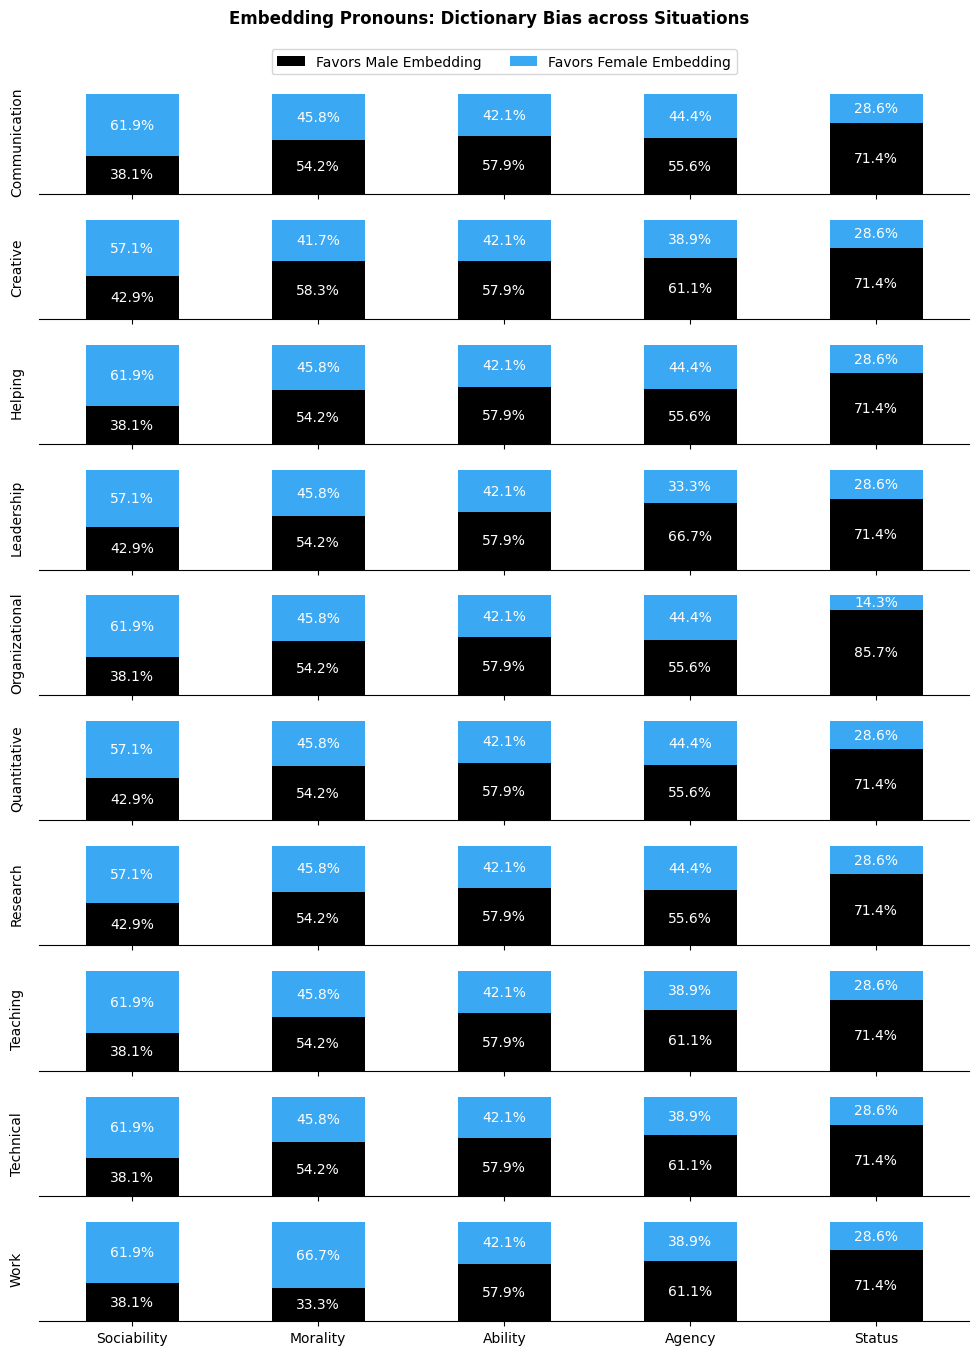

In [17]:
fig, axs = plt.subplots(10,1, figsize=(12, 16))

axs = axs.ravel()

for i, situation in zip(range(10), situation_set):

    dictionary_results_dict[situation].plot(kind='bar', stacked=True, color=[male_color_code, female_color_code], ax = axs[i])
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    for c in axs[i].containers:
        labels = [f"{round(v.get_height()*100,1)}%" if v.get_height() > 0 else '' for v in c]
        axs[i].bar_label(c, labels=labels, label_type='center', color = "white")
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=0)
    axs[i].set_ylabel(situation)
    
    axs[i].set_yticklabels([])
    axs[i].tick_params(left=False)
    axs[i].legend(bbox_to_anchor=(0, 1.4, 1, 0.05), loc='upper center',  ncol = 2)
    
    if i != 0: 
        axs[i].get_legend().remove()
    
    if i != 9: 
        axs[i].set_xticklabels([])
        
    fig.suptitle(f"Embedding {method}: Dictionary Bias across Situations", weight = "bold", y=0.93)
    #plt.savefig(f'{method}_dictionary_bias.pdf', bbox_inches = "tight",transparent=True)

Text(0.5, 1.2, 'Embedding Pronouns: Dictionary Bias')

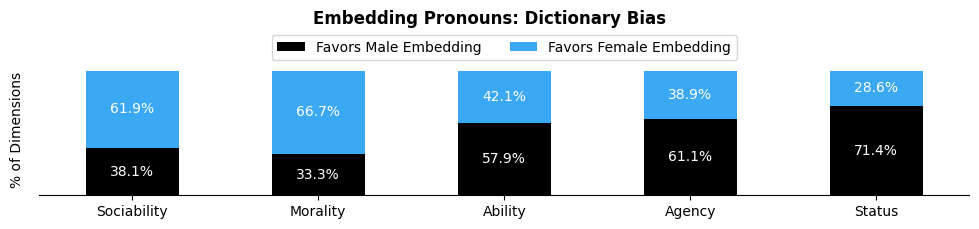

In [18]:
fig, axs = plt.subplots(figsize=(12, 1.7))

dictionary_results_dict[situation].plot(kind='bar', stacked=True, color=[male_color_code, female_color_code], ax = axs)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
for c in axs.containers:
    labels = [f"{round(v.get_height()*100,1)}%" if v.get_height() > 0 else '' for v in c]
    axs.bar_label(c, labels=labels, label_type='center', color = "white")
#axs[i].get_legend().remove()
axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=0)
axs.set_ylabel("% of Dimensions")

axs.set_yticklabels([])
axs.tick_params(left=False)
axs.legend(bbox_to_anchor=(0, 1.4, 1, 0.05), loc='upper center',  ncol = 2)

axs.legend(bbox_to_anchor=(0, 0.98, 1, 0.05), loc='lower center',  ncol = 2)
        
fig.suptitle(f"Embedding {method.capitalize()}: Dictionary Bias", weight = "bold", y=1.2)
#plt.savefig(f'{method}_dictionary_bias.pdf', bbox_inches = "tight",transparent=True)

## 2.2 Plot Individual Dictionaries

In [19]:
# Set dictionary to plot. 
dictionary = "Morality"
dictionary_dimensions = all_dimensions[all_dimensions["Dictionary"] == dictionary]
dictionary_dimensions = dictionary_dimensions.sort_values("Mean Firm")

Text(0.5, 1.0, 'Embedding Pronouns: Average Dictionary Bias per Dimension')

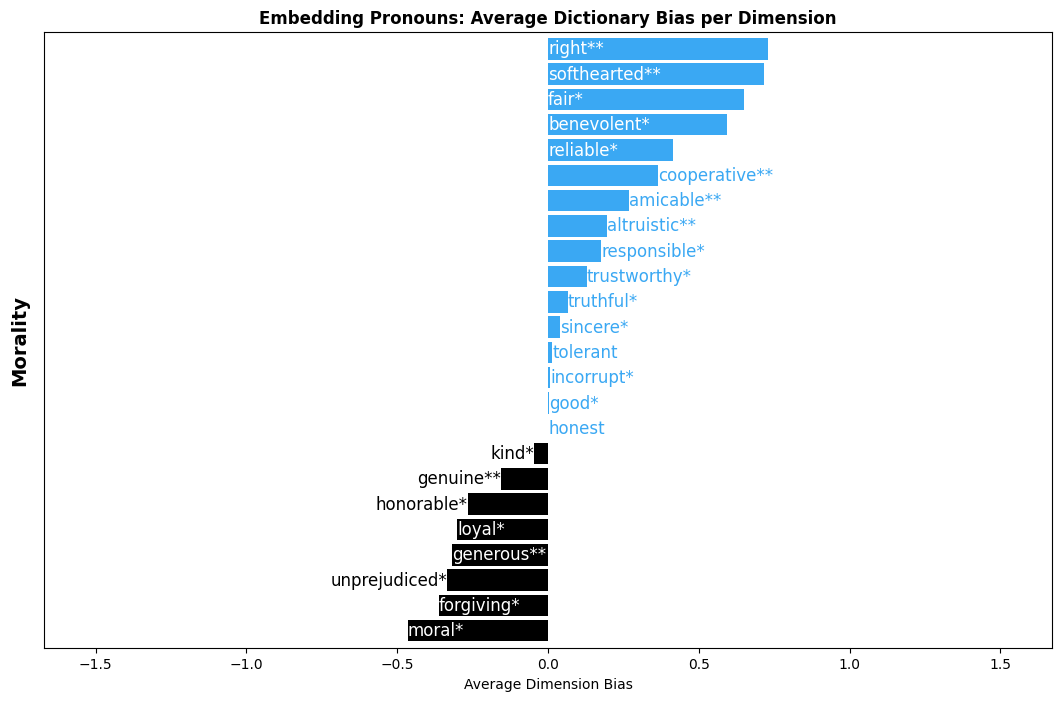

In [20]:
fig, ax = plt.subplots(figsize=(13, len(dictionary_dimensions)/3))

ax = dictionary_dimensions['Mean Firm'].plot(kind='barh',color = (dictionary_dimensions['Mean Firm'] > 0).map({True: female_color_code, False: male_color_code}), width=0.85, label = "Test")
ax.set_xlim(-all_dimensions["Mean Firm"].abs().max()*1.05, all_dimensions["Mean Firm"].abs().max()*1.05)
for i, (p, pr) in enumerate(zip(dictionary_dimensions["Right"], dictionary_dimensions["Mean Firm"])):
    
    r = fig.canvas.get_renderer()
    t = ax.text(0, 0, p, size = 12)
    bb = t.get_window_extent(renderer=r).transformed(plt.gca().transData.inverted())
    width = bb.width
    height = bb.height
    t.remove()
    
    if pr > 0: 
        if width > pr:    
            plt.text(s=p, x=pr, y=i, color=female_color_code, verticalalignment="center", size=12)            
        else: 
            plt.text(s=p, x=0, y=i, color="white", verticalalignment="center", size=12)
        
    else: 
        if -width < pr:
            plt.text(s=p, x=pr-width, y=i, color="black", verticalalignment="center", size=12)
        else: 
            plt.text(s=p, x=pr, y=i, color="white", verticalalignment="center", size=12)

ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none') 
ax.set_xlabel("Average Dimension Bias")
ax.set_ylabel(f"{dictionary}", weight = "bold", size = 14)
ax.set_title(f"Embedding {method}: Average Dictionary Bias per Dimension", weight = "bold")

#plt.savefig(f'{method}_{dictionary}_dictionary_summary.pdf', bbox_inches = "tight",transparent=True)

## 3. Industry Analysis

In [21]:
# Read Company names. 
companies = pd.read_csv("sp500companynames_clean.csv", sep = ";")
companies = companies.dropna()
companies = companies.rename(columns = {"permco":"PERMCO"})

# Read Industry Codes. 
industries = pd.read_csv("industry_query.csv")
industries.dropna(inplace = True)
industries = industries.groupby('PERMCO').first().reset_index()

# Merge Company Names and Industry Codes. 
companies = pd.merge(companies, industries,on='PERMCO', how='left')

# Read industry classification. 
classification = pd.read_csv("industry_classification.csv", sep = ";")

# Classify. 
companies['Sector'] = companies.NAICS.astype(str).str[:2].astype(int)
companies = pd.merge(companies, classification,on='Sector', how='left')
companies = companies.rename(columns = {"PERMCO":"Permco"})

companies.loc[companies["Industry"] == "Administrative and Support and Waste Management and Remediation Services","Industry"] = "Admin., Waste and Remediation"

In [22]:
zscores = {}
for situation in situation_set: 
    res = pd.read_csv(f"./01_Embeddings/Embedd_{method}/{situation}_context/zscores.csv", index_col = 0)
    res = pd.merge(res, companies[["Permco", "Industry"]],on='Permco', how='left')
    zscores[situation] = res

In [23]:
situation_data = zscores["Work"]

situation_data = situation_data[~situation_data["Industry"].isin(["Agriculture, Forestry, Fishing and Hunting", "Arts, Entertainment, and Recreation",
                                      "Construction", "Educational Services", "Health Care and Social Assistance", 
                                      "Management of Companies and Enterprises", "Public Administration"])]

Text(0.5, 0.9, 'Embedding Pronouns: Average Dictionary Bias per Industry for the Work Situation')

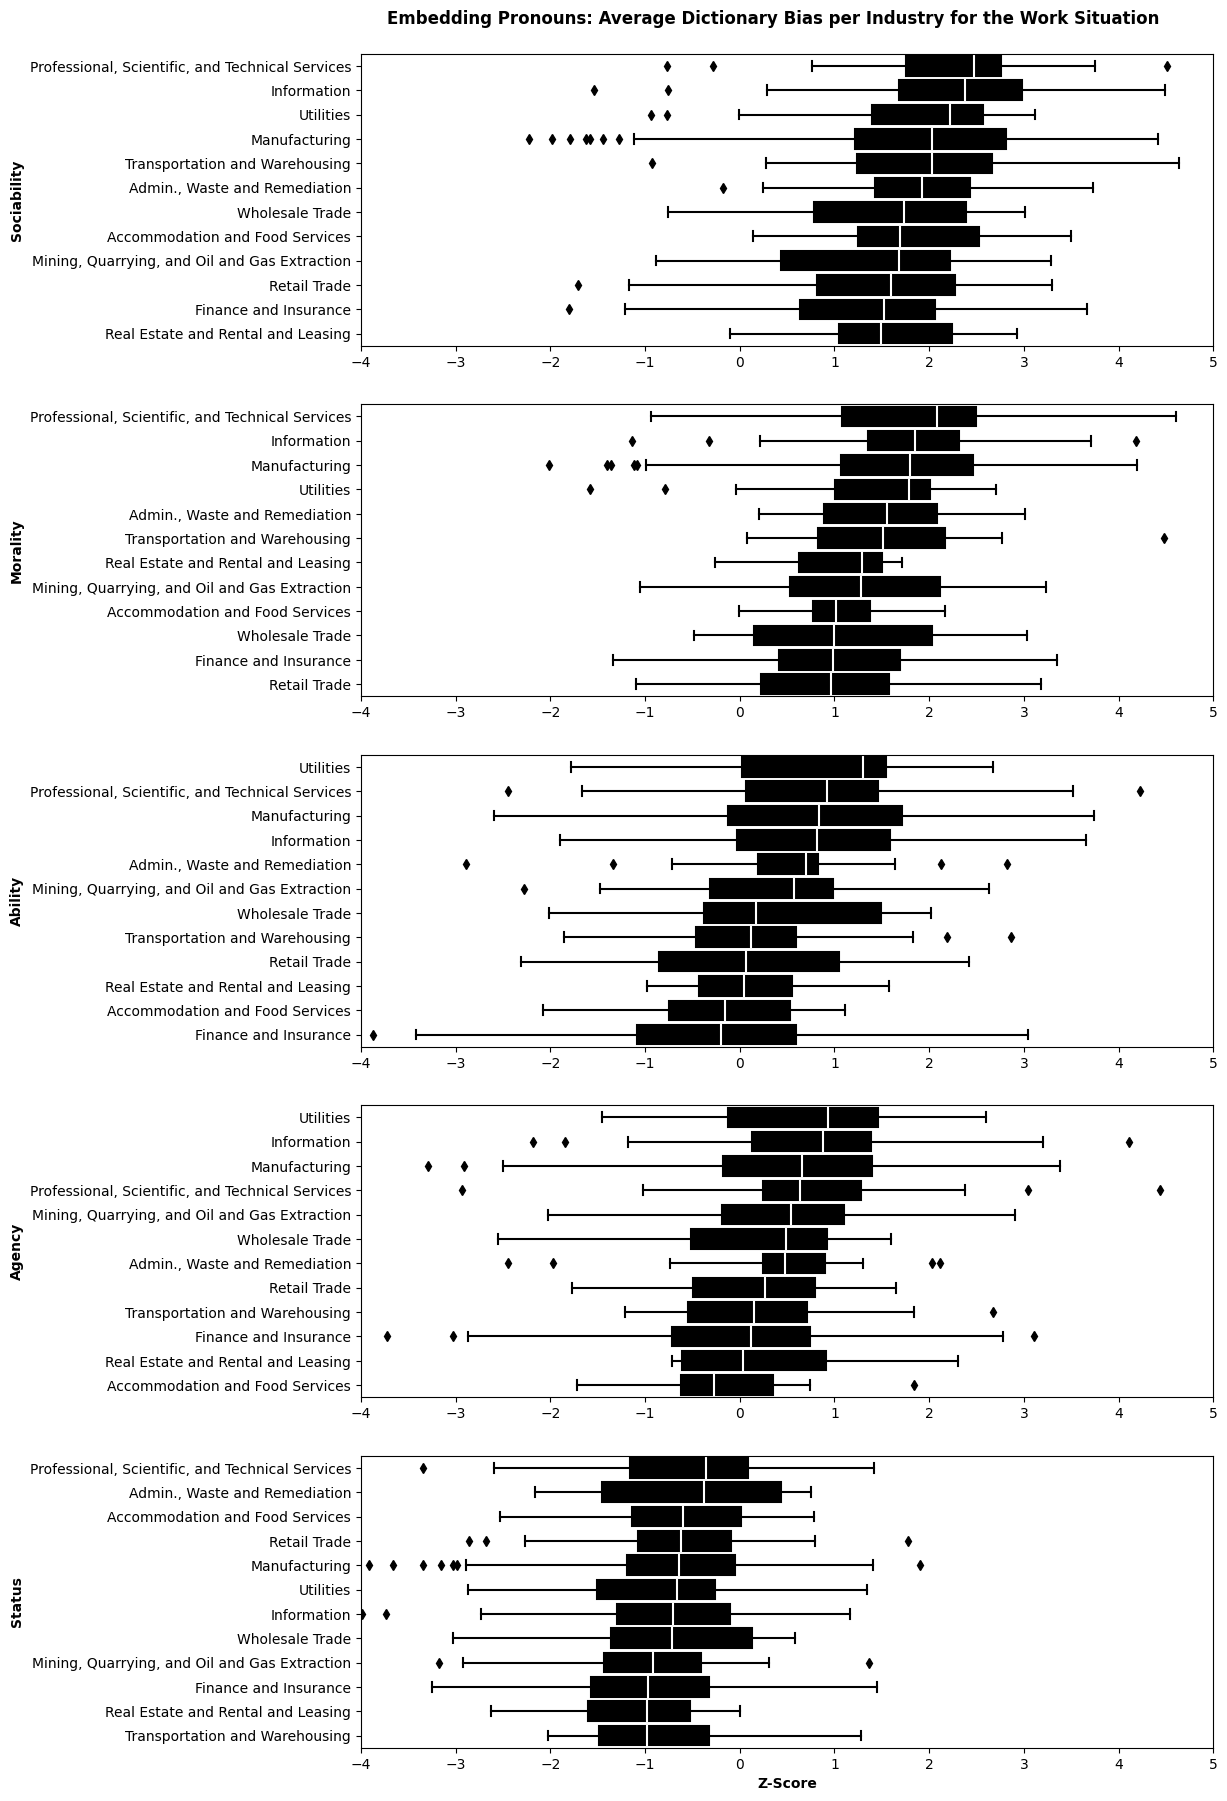

In [24]:
fig, ax = plt.subplots(5,1, figsize=(11, 22))

sociability_order = situation_data[["Industry", "Sociability_Female-Male_zScore"]].groupby(by=["Industry"]).median().sort_values("Sociability_Female-Male_zScore", ascending = False).index
g1 = sns.boxplot(data=situation_data, x="Sociability_Female-Male_zScore", y="Industry", color = "black", ax = ax[0], order = sociability_order, medianprops=dict(color="white"))
ax[0].set_xlim(-4,5)
ax[0].set_ylabel("Sociability", weight = "bold")
g1.set(xlabel=None)

morality_order = situation_data[["Industry", "Morality_Female-Male_zScore"]].groupby(by=["Industry"]).median().sort_values("Morality_Female-Male_zScore", ascending = False).index
g2 = sns.boxplot(data=situation_data, x="Morality_Female-Male_zScore", y="Industry", color = "black", ax = ax[1], order = morality_order, medianprops=dict(color="white"))
ax[1].set_xlim(-4,5)
ax[1].set_ylabel("Morality", weight = "bold")
g2.set(xlabel=None)

ability_order = situation_data[["Industry", "Ability_Female-Male_zScore"]].groupby(by=["Industry"]).median().sort_values("Ability_Female-Male_zScore", ascending = False).index
g3 = sns.boxplot(data=situation_data, x="Ability_Female-Male_zScore", y="Industry", color = "black", ax = ax[2], order = ability_order, medianprops=dict(color="white"))
ax[2].set_xlim(-4,5)
ax[2].set_ylabel("Ability", weight = "bold")
g3.set(xlabel=None)

agency_order = situation_data[["Industry", "Agency_Female-Male_zScore"]].groupby(by=["Industry"]).median().sort_values("Agency_Female-Male_zScore", ascending = False).index
g4 = sns.boxplot(data=situation_data, x="Agency_Female-Male_zScore", y="Industry", color = "black", ax = ax[3], order = agency_order, medianprops=dict(color="white"))
ax[3].set_xlim(-4,5)
ax[3].set_ylabel("Agency", weight = "bold")
g4.set(xlabel=None)

status_order = situation_data[["Industry", "Status_Female-Male_zScore"]].groupby(by=["Industry"]).median().sort_values("Status_Female-Male_zScore", ascending = False).index
g5 = sns.boxplot(data=situation_data, x="Status_Female-Male_zScore", y="Industry", color = "black", ax = ax[4], order = status_order, medianprops=dict(color="white"))
ax[4].set_xlim(-4,5)
ax[4].set_ylabel("Status", weight = "bold")
ax[4].set_xlabel("Z-Score", weight = "bold")

plt.subplots_adjust(hspace=0.2, wspace = 0)
fig.suptitle(f"Embedding {method}: Average Dictionary Bias per Industry for the Work Situation", weight = "bold", y=0.9)

#plt.savefig(f'industry_boxplot_{method}.pdf', bbox_inches = "tight",transparent=True)

In [25]:
z_scores_firms = pd.read_csv("01_Embeddings/Embedd_Firms/Work_context/zscores.csv", index_col = 0).drop(["Permco", "Company"], axis = 1)

z_scores_firms.rename(columns = {"Ability_Female-Male_zScore":"Ability",
                                "Agency_Female-Male_zScore":"Agency",
                                "Morality_Female-Male_zScore":"Morality",
                                "Sociability_Female-Male_zScore":"Sociability",
                                "Status_Female-Male_zScore":"Status"}, inplace = True)

z_scores_pronouns = pd.read_csv("01_Embeddings/Embedd_Pronouns/Work_context/zscores.csv", index_col = 0).drop(["Permco", "Company"], axis = 1)

z_scores_pronouns.rename(columns = {"Ability_Female-Male_zScore":"Ability",
                                "Agency_Female-Male_zScore":"Agency",
                                "Morality_Female-Male_zScore":"Morality",
                                "Sociability_Female-Male_zScore":"Sociability",
                                "Status_Female-Male_zScore":"Status"}, inplace = True)

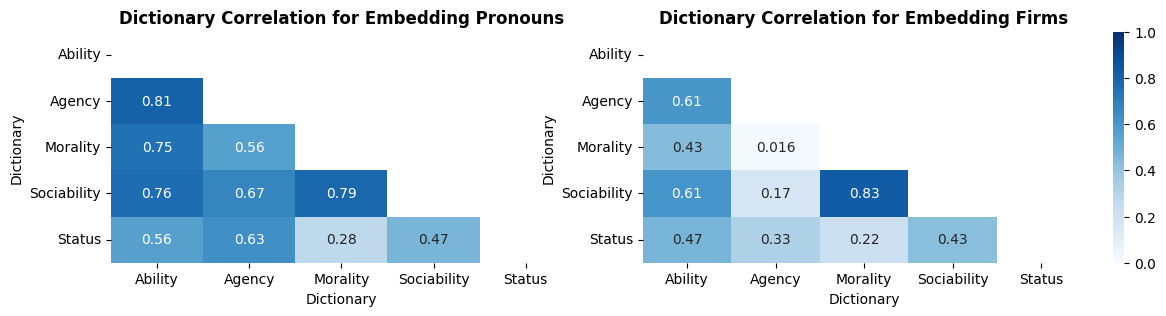

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols=2, figsize=(14, 3),width_ratios=[1, 1.2])

corr_pronouns = z_scores_pronouns.corr()
matrix_pronouns = np.triu(corr_pronouns)

ax1.set_title("Dictionary Correlation for Embedding Pronouns", weight = "bold", size = 12)
sns.heatmap(corr_pronouns, annot = True, mask = matrix_pronouns, cmap="Blues", ax = ax1, vmin = 0, vmax = 1, cbar = False)
ax1.set_ylabel("Dictionary")
ax1.set_xlabel("Dictionary")
corr_firms = z_scores_firms.corr()
matrix_firms = np.triu(corr_firms)

ax2.set_title("Dictionary Correlation for Embedding Firms", weight = "bold", size = 12)
sns.heatmap(corr_firms, annot = True, mask = matrix_firms, cmap="Blues", ax = ax2,vmin = 0, vmax = 1)
ax2.set_ylabel("Dictionary")
ax2.set_xlabel("Dictionary")

plt.subplots_adjust(wspace = 0.14)

#fig.savefig("dictionary_correlation.pdf", bbox_inches='tight')

## 4. Validation

In [54]:
# Define function to get tickers from firm names.
# Adapted from https://gist.github.com/bruhbruhroblox/dd9d981c8c37983f61e423a45085e063
# Results might slightly deviate over time, depending on how many tickers are matched via yfinance. 

def get_ticker(row):
    try: 
        company_name = row["cleanedname"]
        yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
        user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
        params = {"q": company_name, "quotes_count": 1, "country": "United States"}

        res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
        data = res.json()

        company_code = data['quotes'][0]['symbol']

        return company_code
    
    except:
        return "NaN"

In [55]:
# Obtain tickers for firm names. 
companies = pd.read_csv("sp500companynames_clean.csv", sep = ";").dropna()
companies["Ticker"] = companies.apply(lambda row: get_ticker(row), axis = 1)

# Consider only companies with ticker match. 
companies_ticker = companies[companies["Ticker"] != "NaN"]

In [56]:
# Export for wrds query. 
#companies_ticker["Ticker"].to_csv('ticker.txt', sep='\t', index=False)

In [57]:
# Read and clean wrds query result.

complaints = pd.read_csv("query_results.csv").dropna()
complaints.rename(columns = {"DIV_con_num":"Total Number of Diversity Concerns (1991 to 2013)"}, inplace = True)

# Obtain average number of diversity concerns per reporting year. 
complaints = complaints.groupby("Ticker").mean().reset_index()
complaints = complaints[["Total Number of Diversity Concerns (1991 to 2013)", "Ticker"]]

In [58]:
# Merge query data with company names and tickers. 

result = pd.merge(complaints, companies_ticker, how="left", on=["Ticker"])
result.rename(columns = {"permco":"Permco"}, inplace = True)

In [59]:
# Read, merge and clean firm results and query results for both embedding methods. 

zscores_firms = pd.read_csv("01_Embeddings/Embedd_Firms/Work_context/zscores.csv", index_col = 0)
zscores_pronouns = pd.read_csv("01_Embeddings/Embedd_Pronouns/Work_context/zscores.csv", index_col = 0)

firms_df = pd.merge(result, zscores_firms, how="left", on=["Permco"])
pronouns_df = pd.merge(result, zscores_pronouns, how="left", on=["Permco"])

firms_df.rename(columns = {"Ability_Female-Male_zScore":"Ability",
                           "Agency_Female-Male_zScore":"Agency",
                           "Morality_Female-Male_zScore":"Morality",
                           "Sociability_Female-Male_zScore":"Sociability",
                           "Status_Female-Male_zScore":"Status", 
                           "Total Number of Diversity Concerns (1991 to 2013)":"Diversity Concerns"}, inplace = True)

pronouns_df.rename(columns = {"Ability_Female-Male_zScore":"Ability",
                           "Agency_Female-Male_zScore":"Agency",
                           "Morality_Female-Male_zScore":"Morality",
                           "Sociability_Female-Male_zScore":"Sociability",
                           "Status_Female-Male_zScore":"Status", 
                           "Total Number of Diversity Concerns (1991 to 2013)":"Diversity Concerns"}, inplace = True)

## 4.1 Single coefficients

In [119]:
dictionaries = ["Ability", "Agency", "Morality", "Sociability", "Status"]

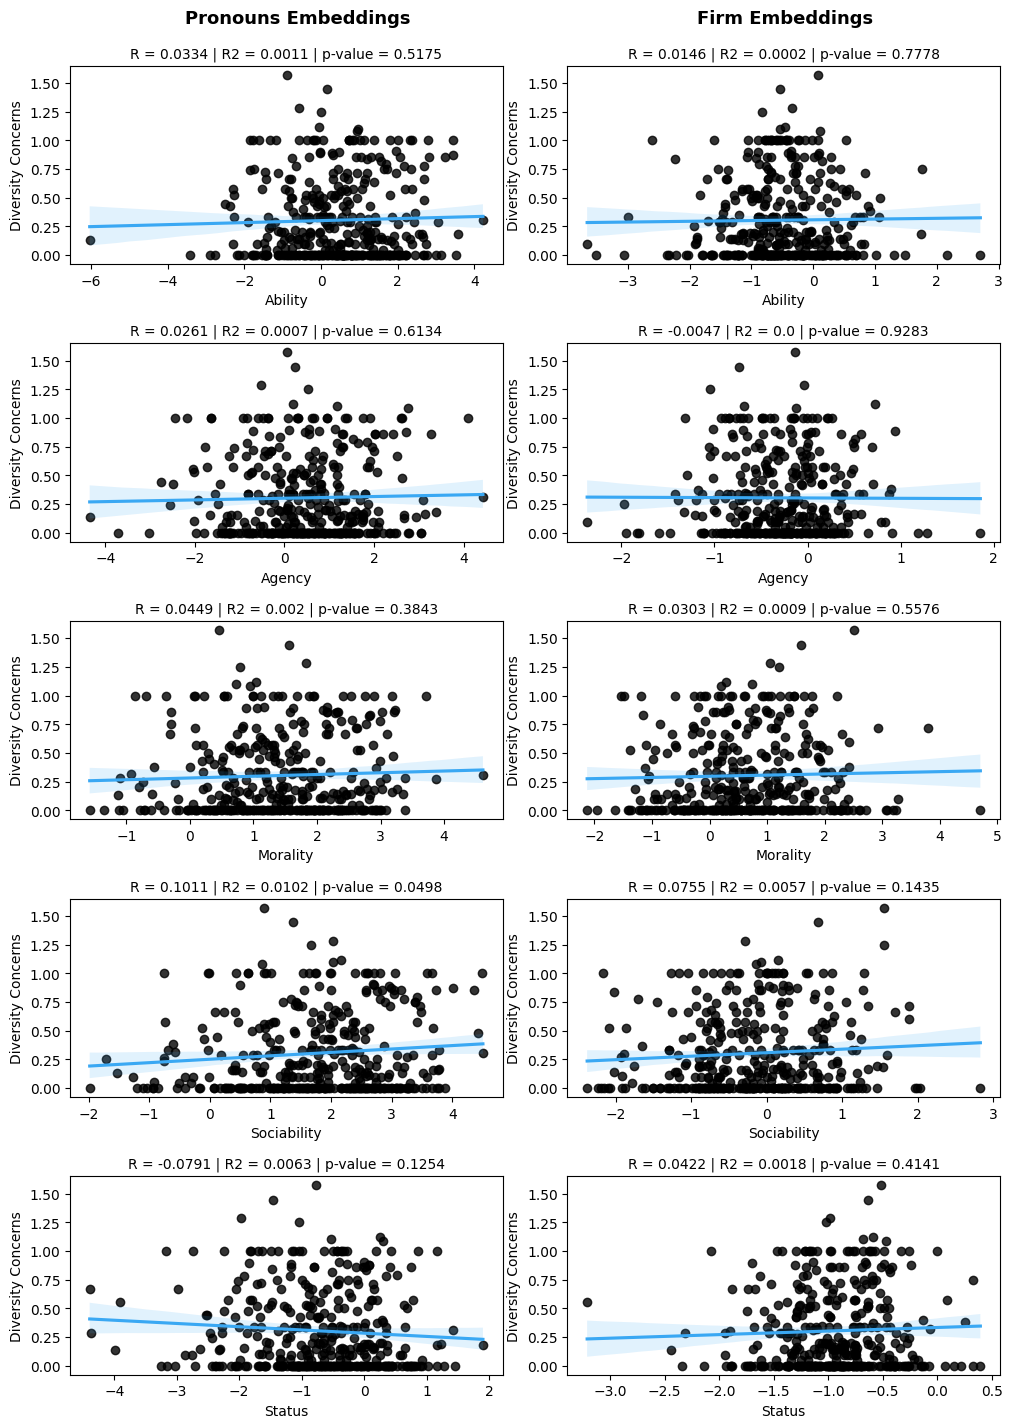

In [166]:
fig, axs = plt.subplots(5,2, figsize=(12, 17))

axs = axs.ravel()

for dic, i in zip(dictionaries, range(10)[::2]):
    model = stats.linregress(x = pronouns_df[dic], y=pronouns_df["Diversity Concerns"], alternative='two-sided')
    sns.regplot(data = pronouns_df, x = dic, y = "Diversity Concerns", ax = axs[i], color = "black", line_kws={"color": "#3AA8F3"})
    axs[i].set_title(f"R = {round(model.rvalue, 4)} | R2 = {round(model.rvalue**2, 4)} | p-value = {round(model.pvalue, 4)}", size = 10)
    
for dic, i in zip(dictionaries, range(1,10)[::2]):
    model = stats.linregress(x = firms_df[dic], y=firms_df["Diversity Concerns"], alternative='two-sided')
    sns.regplot(data = firms_df, x = dic, y = "Diversity Concerns", ax = axs[i], color = "black", line_kws={"color": "#3AA8F3"})
    axs[i].set_title(f"R = {round(model.rvalue, 4)} | R2 = {round(model.rvalue**2, 4)} | p-value = {round(model.pvalue, 4)}", size = 10)

plt.text(s = "Pronouns Embeddings", y = 11.7, x = -6.9, weight = "bold", size = 13)
plt.text(s = "Firm Embeddings", y = 11.7, x = -2.2, weight = "bold", size = 13)
plt.subplots_adjust(wspace = 0.15, hspace = 0.4)

#plt.savefig('correlation_analysis.pdf', bbox_inches = "tight",transparent=True)

## 4.2 Multivariate Analysis Pronouns

In [171]:
x = pronouns_df[['Ability','Agency', "Morality", "Sociability", "Status"]]
y = pronouns_df['Diversity Concerns']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Diversity Concerns   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.083
Date:                Sun, 12 Feb 2023   Prob (F-statistic):            0.00969
Time:                        16:39:05   Log-Likelihood:                -131.04
No. Observations:                 377   AIC:                             274.1
Df Residuals:                     371   BIC:                             297.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1772      0.045      3.944      

In [87]:
#print(model.summary().as_latex())

## 4.3 Multivariate Analysis Firms

In [173]:
x = firms_df[['Ability','Agency', "Morality", "Sociability", "Status"]]
y = firms_df['Diversity Concerns']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Diversity Concerns   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9490
Date:                Sun, 12 Feb 2023   Prob (F-statistic):              0.449
Time:                        16:39:19   Log-Likelihood:                -136.32
No. Observations:                 377   AIC:                             284.6
Df Residuals:                     371   BIC:                             308.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3360      0.046      7.307      

In [88]:
#print(model.summary().as_latex())